2024-08-12 08:43:17.533326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 08:43:17.533379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 08:43:17.534778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 08:43:17.543212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 08:43:18.596365: W tensorflow/compiler/tf2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

2024-08-12 08:44:26.795862: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-12 08:44:27.356614: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-12 08:44:28.337244: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-12 08:44:33.794977: I external/local_xla/xla/service/service.cc:168] XLA service 0x7576146cf720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-12 08:44:33.795019: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-12 08:44:33.825699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723452273.984145    2639 device_compiler.h:1

86/86 [==============================] - 97s 279ms/step - loss: 0.3338 - mean_io_u: 0.1326 - val_loss: 0.3632 - val_mean_io_u: 0.1331
Epoch 2/20
86/86 [==============================] - 10s 118ms/step - loss: 0.2719 - mean_io_u: 0.1326 - val_loss: 0.3927 - val_mean_io_u: 0.1331
Epoch 3/20
86/86 [==============================] - 10s 118ms/step - loss: 0.2456 - mean_io_u: 0.1326 - val_loss: 0.4395 - val_mean_io_u: 0.1331
Epoch 4/20
86/86 [==============================] - 10s 118ms/step - loss: 0.2190 - mean_io_u: 0.1326 - val_loss: 0.4639 - val_mean_io_u: 0.1332
Epoch 5/20
86/86 [==============================] - 10s 118ms/step - loss: 0.1975 - mean_io_u: 0.1328 - val_loss: 0.3411 - val_mean_io_u: 0.1333
Epoch 6/20
86/86 [==============================] - 10s 118ms/step - loss: 0.1796 - mean_io_u: 0.1329 - val_loss: 0.3376 - val_mean_io_u: 0.1331
Epoch 7/20
86/86 [==============================] - 10s 118ms/step - loss: 0.1610 - mean_io_u: 0.1334 - val_loss: 0.3243 - val_mean_io_u: 0.1

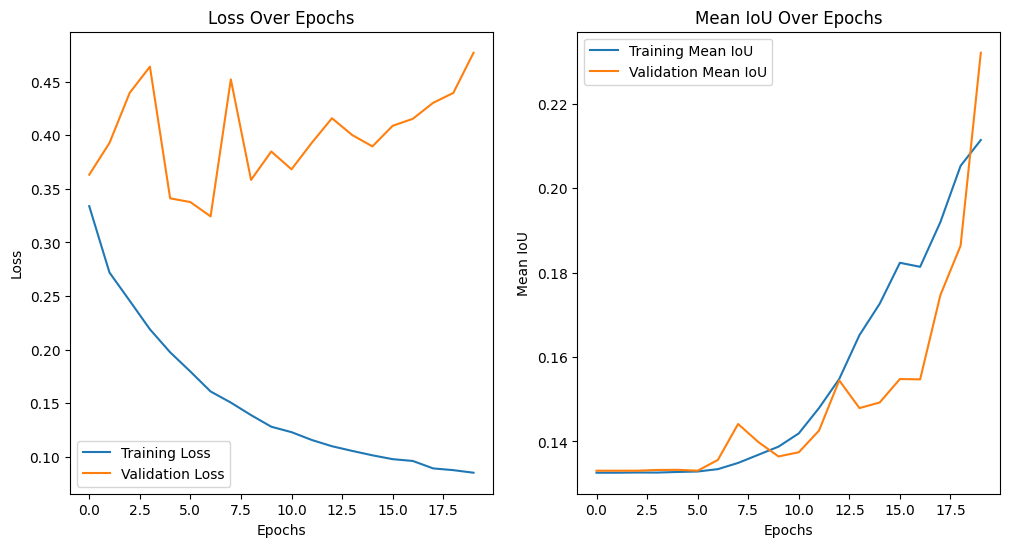

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt

# Define the target image size
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Directories
data_dir = "/home/ubuntu/BTS/Breast_Cancer_Segmentation/Mass_Data"  # Replace with your path

# Load images and masks
def load_data(data_dir):
    images = []
    masks = []
    for label in ['Benign', 'Malignant']:
        image_dir = os.path.join(data_dir, label)
        for filename in os.listdir(image_dir):
            if filename.endswith('.png') and '_MASK' not in filename:
                # Load the image
                img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)
                mask_filename = filename.replace('.png', '_MASK.png')
                mask_path = os.path.join(image_dir, mask_filename)

                # Load the corresponding mask if it exists
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None and mask is not None:
                        images.append(img)
                        masks.append(mask)

    # Resize images and masks
    images = np.array([cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in images])
    masks = np.array([cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) for mask in masks])

    return np.array(images), np.array(masks)

images, masks = load_data(data_dir)

# Normalize images and masks
images = images / 255.0
masks = masks / 255.0
masks = masks[..., np.newaxis]  # Add a channel dimension to the masks

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing: Convert single channel to 3-channel by repeating the grayscale channel
X_train_3ch = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_3ch = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_3ch = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Define the DeepLabV3Plus model
def DeepLabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Atrous Spatial Pyramid Pooling
    b4 = Conv2D(256, (1, 1), padding="same", use_bias=False)(base_model.output)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)

    # Decoder
    x = Conv2DTranspose(256, 3, strides=2, padding="same")(b4)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, base_model.get_layer("conv3_block12_concat").output])
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = Conv2D(num_classes, 1, padding="same")(x)

    # Up-sample to match the input shape
    x = UpSampling2D(size=(4, 4))(x)

    # Final activation layer for binary segmentation
    x = Activation('sigmoid')(x)

    # Model Definition
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Re-initialize and compile the model
model = DeepLabV3Plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

# Display the model summary to check output shape
model.summary()

# Train the model
EPOCHS = 20
BATCH_SIZE = 16

history = model.fit(
    X_train_3ch, y_train,
    validation_data=(X_val_3ch, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Mean IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.title('Mean IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()

plt.show()


10/10 [==============================] - 11s 375ms/step


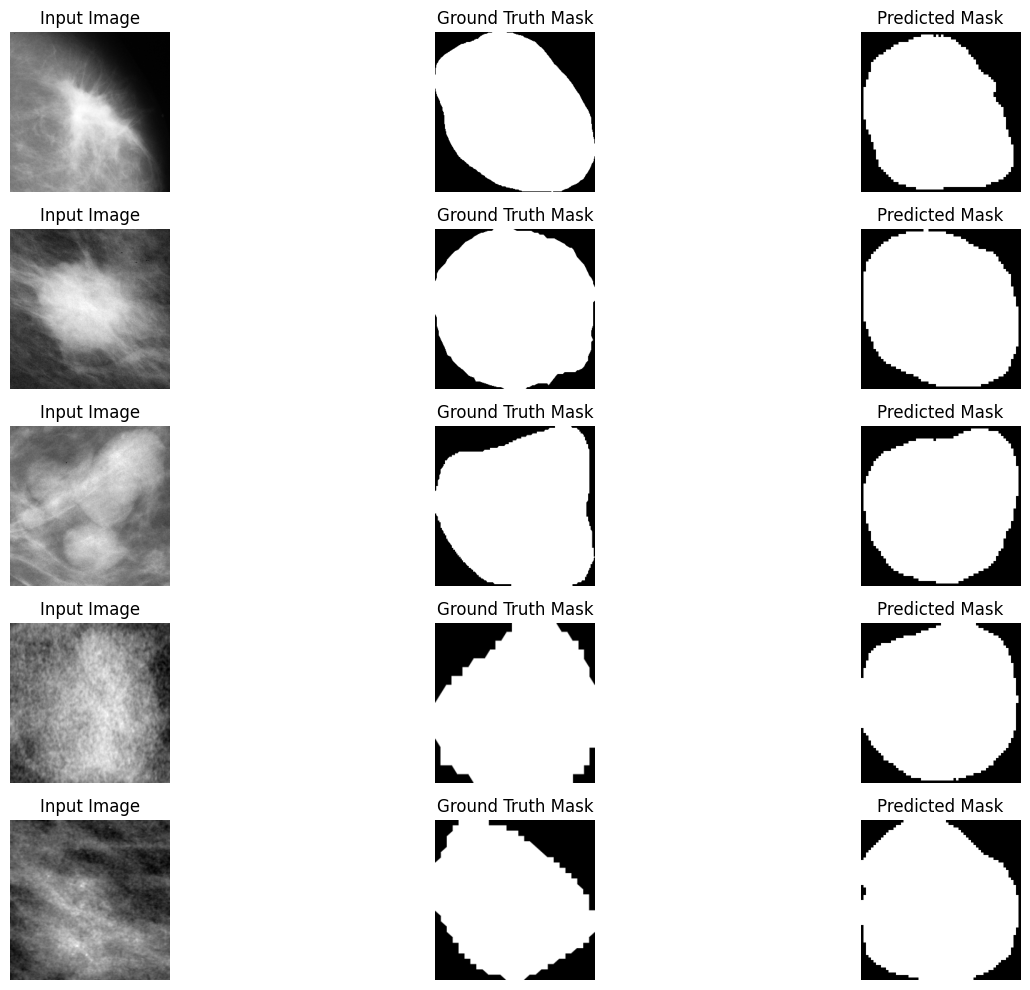

In [2]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_3ch)

# Threshold the predictions to create binary masks
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Visualize a few examples from the test set
num_examples = 5  # Number of examples to visualize

plt.figure(figsize=(15, 10))
for i in range(num_examples):
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(y_pred_thresholded[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()
